# 📌 Assignment Overview: Augmented Reality with Planar Homographies
In this assignment, we build an **Augmented Reality (AR)** application using **planar homographies**. Our goal is to overlay each frame of a source video onto a book in a target video, frame by frame, creating an illusion that the video is playing on the book’s surface.

We use `book.mov` as the base video (showing a static book) and `ar_source.mov` as the video we want to overlay. The main challenge lies in **accurately tracking the planar surface of the book** and mapping frames onto it in a consistent and realistic manner.

This involves multiple computer vision techniques, including:

* Feature matching with SIFT descriptors

* Homography matrix estimation

* Image warping and perspective transformation

* Frame cropping to fit aspect ratios

* Video frame overlay for AR effect

## Import Packages

In [106]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Load the Book Image

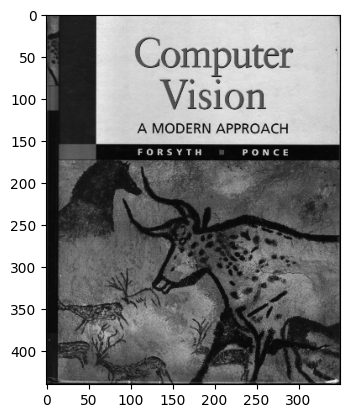

In [107]:
# Load the book image
book_img = cv2.imread('material/cv_cover.jpg', cv2.IMREAD_GRAYSCALE)

# Show the book image
plt.imshow(book_img, cmap='grey')

## Load the First Frame

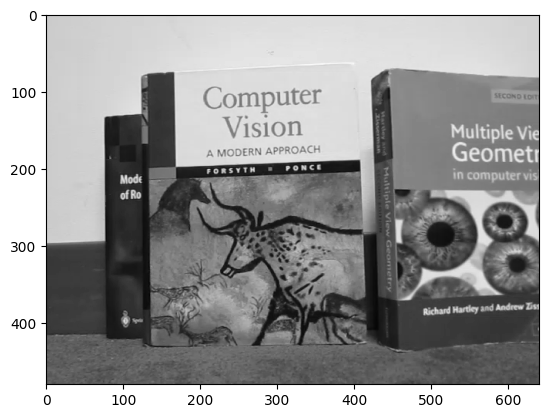

In [108]:
# Load the first frame from the video
cap = cv2.VideoCapture('material/book.mov')
ret, frame = cap.read()
cap.release()

# Convert the frame to grayscale
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Show the first frame
plt.imshow(frame_gray, 'grey')

# 🧠 Implementation Steps Explained

## 1. Get Correspondences

* Detect SIFT keypoints in the book image and the first frame of the book video.

* Use OpenCV’s Brute Force Matcher with KNN (k=2) to match descriptors.

* Apply ratio test to retain only strong matches.

* Select 50 high-quality matches and visualize them across both images.

### Detecting Keypoints using SIFT Descriptor

In [109]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect and compute keypoints/descriptors
kp1, des1 = sift.detectAndCompute(book_img, None)
kp2, des2 = sift.detectAndCompute(frame_gray, None)

### Matching Keypoints using Brute-Force Matcher

In [110]:
# Brute-force matcher with L2 norm and KNN
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Sort by distance and keep top 50
good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

### Visualize the Matches

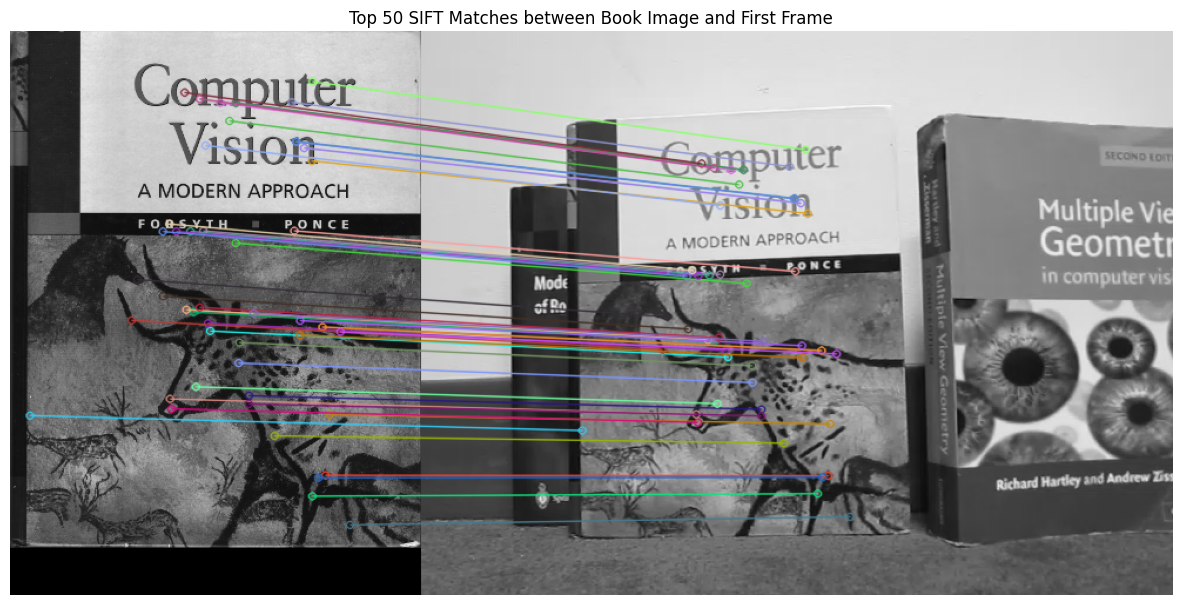

In [111]:
# Draw matches
matched_img = cv2.drawMatches(book_img, kp1, frame_gray, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show result
plt.figure(figsize=(15, 8))
plt.imshow(matched_img, cmap='gray')
plt.title("Top 50 SIFT Matches between Book Image and First Frame")
plt.axis('off')
plt.show()

## 2. Estimate the Homography

* Implement a function to compute the 3×3 homography matrix H from matched point pairs using Direct Linear Transform (DLT).

* Normalize points and solve the system Ax = b to retrieve H, assuming H[2,2] = 1 to reduce degrees of freedom.

* Validate by transforming source points with H and comparing against their targets.

### Compute the Homography Matrix

In [112]:
def compute_homography(src_pts, dst_pts):
    """
    Compute homography matrix H such that: dst_pts ≈ H * src_pts
    src_pts and dst_pts should be Nx2 numpy arrays.
    """
    assert src_pts.shape[0] >= 4, "Need at least 4 correspondences"
    
    n = src_pts.shape[0]
    A = []

    for i in range(n):
        x, y = src_pts[i]
        u, v = dst_pts[i]
        A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
        A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])

    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape((3, 3))

    # Normalize H so that H[2, 2] = 1
    H /= H[2, 2]

    return H

# Example: Use good matches from Part 1.1
def get_correspondence_points(kp1, kp2, matches, num_points=8): # Select the best 8 matches to compute the homography matrix
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:num_points]])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:num_points]])
    return src_pts, dst_pts

# Get corresponding points
src_pts, dst_pts = get_correspondence_points(kp1, kp2, good_matches, num_points=8)

# Compute homography
H = compute_homography(src_pts, dst_pts)
print("Homography Matrix:\n", H)

Homography Matrix:
 [[ 7.60041509e-01 -6.24903873e-03  1.20937242e+02]
 [-5.52994910e-02  7.64676530e-01  7.84601592e+01]
 [-1.11334617e-04 -1.10553404e-04  1.00000000e+00]]


### Homography Matrix Verification

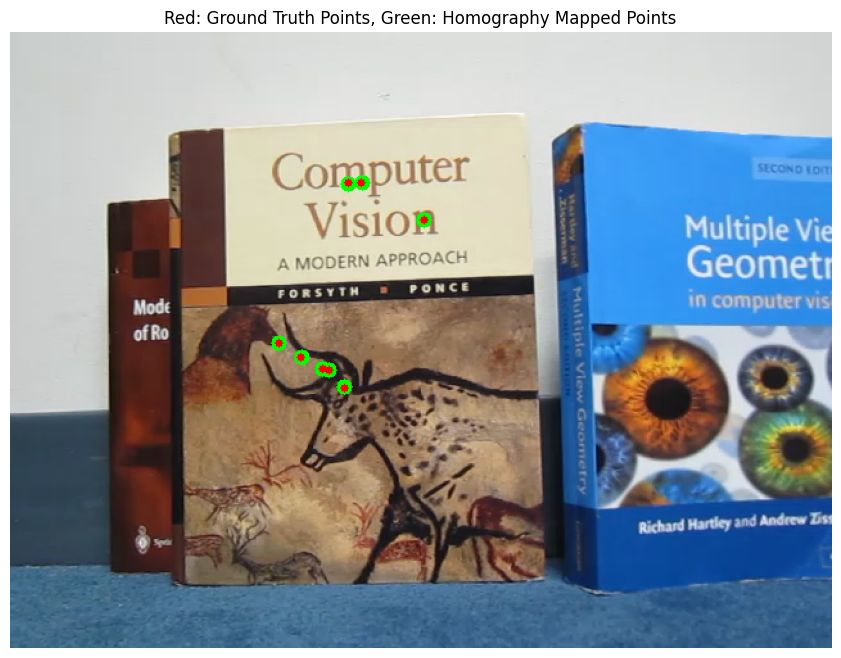

In [113]:
# Validate: map book points to frame and draw
src_pts_homo = np.concatenate([src_pts, np.ones((src_pts.shape[0], 1))], axis=1).T  # Change to Homogeneous Coordinates
mapped_pts_homo = H @ src_pts_homo  # Map points using Homography Matrix
mapped_pts = (mapped_pts_homo[:2] / mapped_pts_homo[2]).T  # Normalize / Handle Homogeneous and Non-homogeneous Coordinates

test_frame = frame.copy()

# Draw original and mapped points
for pt in mapped_pts:
    cv2.circle(test_frame, tuple(np.int32(pt)), 6, (0, 255, 0), -1)

for pt in dst_pts:
    cv2.circle(test_frame, tuple(np.int32(pt)), 3, (0, 0, 255), -1)

plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
plt.title("Red: Ground Truth Points, Green: Homography Mapped Points")
plt.axis('off')
plt.show()

## 3. Book Corner Projection

* Identify the 4 corner coordinates of the book cover image.

* Use the homography to project these corners into the video frame space.

* This gives us the dynamic location of the book in the video.

### Calculate Book Coordinates

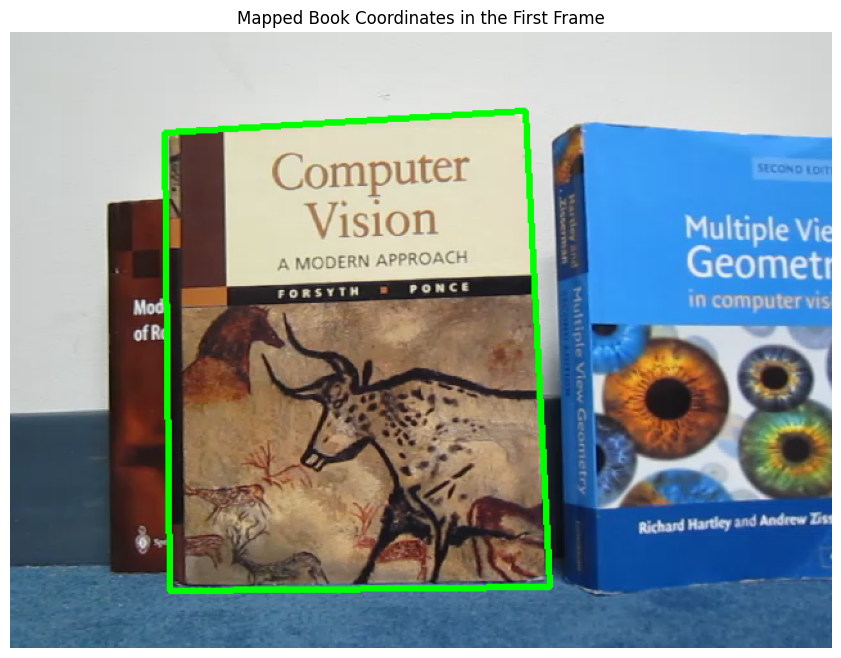

In [114]:
def get_book_corners(book_img):
    """Returns the 4 corners of the book image in (x, y) format."""
    h, w = book_img.shape[:2]
    return np.float32([
        [0, 0],       # Top-left
        [w - 1, 0],   # Top-right
        [w - 1, h - 1],  # Bottom-right
        [0, h - 1]    # Bottom-left
    ]).reshape(-1, 1, 2)

def warp_corners(H, corners):
    """Applies homography to corners and returns warped points."""
    return cv2.perspectiveTransform(corners, H)

def draw_projected_box(image, corners):
    """Draws a polygon from 4 corner points on the image."""
    img_copy = image.copy()
    cv2.polylines(img_copy, [np.int32(corners)], isClosed=True, color=(0, 255, 0), thickness=3)
    return img_copy

# Get the book corners from the book image
book_corners = get_book_corners(book_img)

# Warp the book corners using the homography matrix
warped_book_corners = warp_corners(H, book_corners)

# Draw the mapped corners on the first video frame
frame_with_box = draw_projected_box(frame, warped_book_corners)

# Show the result
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(frame_with_box, cv2.COLOR_BGR2RGB))
plt.title("Mapped Book Coordinates in the First Frame")
plt.axis('off')
plt.show()

## 4. Crop AR Source Frames

* Due to the aspect ratio mismatch between book cover and video, we must crop the AR source frames centrally.

* Compute the target dimensions based on the projected book corners to crop each frame accordingly.

### Crop AR Video Frames

In [115]:
def remove_black_borders(frame, threshold=10):
    """
    Remove black borders (top and bottom) from the frame.
    Returns the frame with borders removed.
    `threshold` defines how dark a row must be considered 'black'.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape

    # Sum pixel intensities row-wise
    row_sums = np.sum(gray, axis=1)
    row_avg = row_sums / w

    # Find top non-black row
    top = 0
    for i in range(h):
        if row_avg[i] > threshold:
            top = i
            break

    # Find bottom non-black row
    bottom = h - 1
    for i in range(h - 1, -1, -1):
        if row_avg[i] > threshold:
            bottom = i
            break

    # Crop out black borders
    return frame[top:bottom+1, :]

def calculate_book_aspect_ratio(book_corners):
    """Calculate the aspect ratio (width/height) of the book using corner coordinates."""
    width = np.linalg.norm(book_corners[1] - book_corners[0])  # top-right - top-left
    height = np.linalg.norm(book_corners[3] - book_corners[0])  # bottom-left - top-left
    return width / height

def compute_crop_dimensions(frame_shape, target_aspect):
    """Compute the crop dimensions needed to match a target aspect ratio."""
    h, w = frame_shape[:2]
    frame_aspect = w / h

    if frame_aspect > target_aspect:
        # Frame is too wide, crop width
        new_width = int(h * target_aspect)
        x_start = (w - new_width) // 2
        crop_coords = (0, x_start, h, new_width)
    else:
        # Frame is too tall, crop height
        new_height = int(w / target_aspect)
        y_start = (h - new_height) // 2
        crop_coords = (y_start, 0, new_height, w)

    return crop_coords

def crop_frame_center(frame, crop_coords):
    """Crop the frame using given coordinates."""
    y, x, h, w = crop_coords
    return frame[y:y+h, x:x+w]

def crop_ar_frame_to_book_aspect(frame, book_corners):
    """Main function to crop AR frame to match the book aspect ratio."""
    cleaned_frame = remove_black_borders(frame)
    book_aspect = calculate_book_aspect_ratio(book_corners)
    crop_coords = compute_crop_dimensions(cleaned_frame.shape, book_aspect)
    cropped_frame = crop_frame_center(cleaned_frame, crop_coords)
    return cropped_frame

### Testing on the AR Video

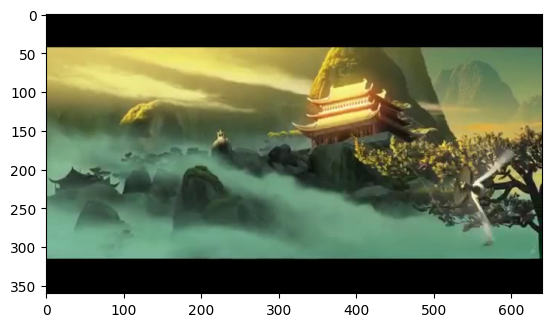

In [116]:
# Load the first frame from the video
cap = cv2.VideoCapture('material/ar_source.mov')
ret, ar_frame = cap.read()
cap.release()

# Convert the frame to grayscale
ar_frame_test = cv2.cvtColor(ar_frame, cv2.COLOR_BGR2RGB)

# Show the first frame
plt.imshow(ar_frame_test)

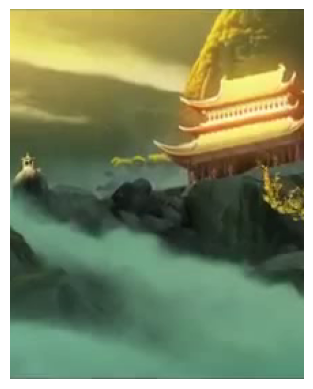

In [117]:
cropped_frame = crop_ar_frame_to_book_aspect(ar_frame, book_corners)

# Show the result
plt.imshow(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## 5. Overlay the AR Frame

* Warp the cropped frame to match the perspective of the book using the previously computed homography.

* Replace the region of the book in the video with the warped frame to simulate the AR effect.

### Overlay the First Frame of the Two Videos

In [118]:
def overlay_ar_on_frame(base_frame, ar_img, target_corners):
    """
    Warps the AR image to the target corners and overlays it on the base frame.
    """
    h, w = ar_img.shape[:2]

    # Define source corners of the AR image
    src_corners = np.float32([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]])

    # Compute homography using the custom function
    H_ar = compute_homography(src_corners, target_corners.reshape(4, 2))

    # Warp AR image to fit the book area
    warped_ar = cv2.warpPerspective(ar_img, H_ar, (base_frame.shape[1], base_frame.shape[0]))

    # Create mask for overlay
    mask = np.zeros_like(base_frame, dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(target_corners), (255, 255, 255))

    # Combine images using the mask
    inv_mask = cv2.bitwise_not(mask)
    background = cv2.bitwise_and(base_frame, inv_mask)
    foreground = cv2.bitwise_and(warped_ar, mask)
    result = cv2.add(background, foreground)

    return result

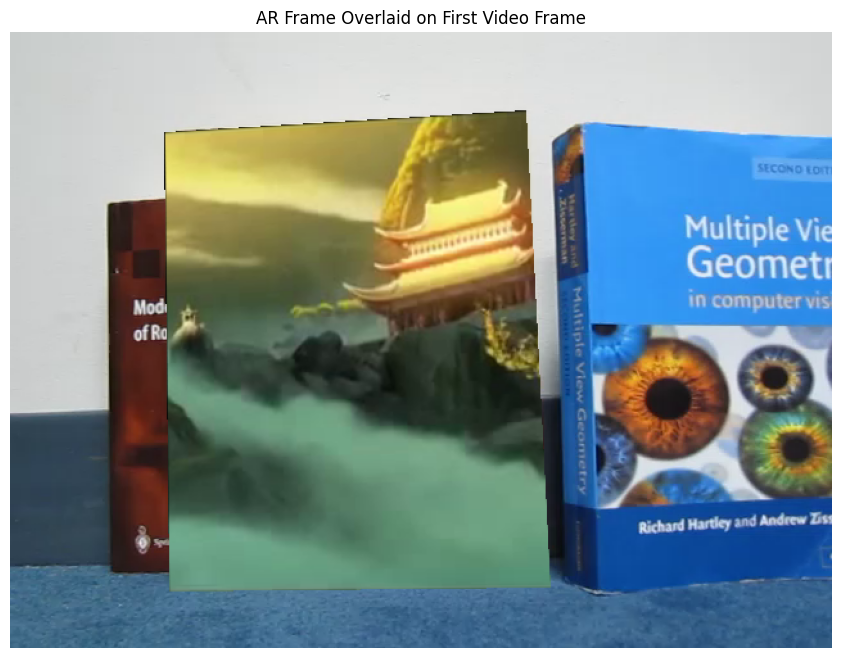

In [119]:
# Apply overlay on the first frame
ar_first_overlay = overlay_ar_on_frame(frame, cropped_frame, warped_book_corners)

# Show the result
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(ar_first_overlay, cv2.COLOR_BGR2RGB))
plt.title("AR Frame Overlaid on First Video Frame")
plt.axis('off')
plt.show()

## 6. Generate the Final AR Video

Repeat the process for every frame:

* Detect book position via inter-frame homography or tracking.

* Warp and overlay each cropped AR frame.

* Assemble the modified frames into a new output video.

### Do this for ALL FRAMES

In [120]:
def compute_homography_ransac(src_pts, dst_pts, threshold=3.0, iterations=1000):
    max_inliers = []
    best_H = None
    n_points = src_pts.shape[0]

    for _ in range(iterations):
        idx = np.random.choice(n_points, 4, replace=False)
        H = compute_homography(src_pts[idx], dst_pts[idx])

        # Project all src_pts using H
        src_proj = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), H).reshape(-1, 2)
        error = np.linalg.norm(dst_pts - src_proj, axis=1)

        inliers = error < threshold
        if np.sum(inliers) > len(max_inliers):
            max_inliers = inliers
            best_H = H

    return best_H

In [ ]:
# Load book reference image
book_img = cv2.imread('material/cv_cover.jpg', cv2.IMREAD_GRAYSCALE)
book_kp, book_des = sift.detectAndCompute(book_img, None)

# Re-open video streams
book_cap = cv2.VideoCapture('material/book.mov')
ar_cap = cv2.VideoCapture('material/ar_source.mov')

# Video properties
fps = int(book_cap.get(cv2.CAP_PROP_FPS))
width = int(book_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(book_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter('output_ar.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))

frame_idx = 0
while True:
    ret_book, book_frame = book_cap.read()
    ret_ar, ar_frame = ar_cap.read()

    if not ret_book or not ret_ar:
        break

    book_gray = cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY)

    # Detect keypoints in current book frame
    kp2, des2 = sift.detectAndCompute(book_gray, None)

    matches = bf.knnMatch(book_des, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 10:
        # Extract matched points
        src_pts = np.float32([book_kp[m.queryIdx].pt for m in good_matches])
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

        # Compute new homography
        # H_frame, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
        H_frame = compute_homography_ransac(src_pts, dst_pts)
        # H_frame = compute_homography(src_pts, dst_pts)

        # Warp book corners to this frame
        book_corners = get_book_corners(book_img)
        warped_corners = cv2.perspectiveTransform(book_corners, H_frame)

        cropped_ar = crop_ar_frame_to_book_aspect(ar_frame, book_corners)

        # Overlay AR on book frame
        result_frame = overlay_ar_on_frame(book_frame, cropped_ar, warped_corners)

    else:
        # Fallback: no enough matches, use original frame
        print(f"Frame {frame_idx}: not enough matches, skipping overlay.")
        result_frame = book_frame

    out.write(result_frame)
    frame_idx += 1

book_cap.release()
ar_cap.release()
out.release()
print("✅ Final AR video with dynamic tracking saved as output_ar.avi")

✅ Final AR video with dynamic tracking saved as output_ar.avi
